<a href="https://colab.research.google.com/github/meangreen59/demo_app/blob/master/Exercise_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
!wget https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv

--2022-02-23 19:55:47--  https://lazyprogrammer.me/course_files/nlp/tmdb_5000_movies.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5698602 (5.4M) [text/csv]
Saving to: ‘tmdb_5000_movies.csv’

tmdb_5000_movies.cs 100%[===================>]   5.43M  2.47MB/s    in 2.2s    

2022-02-23 19:55:50 (2.47 MB/s) - ‘tmdb_5000_movies.csv’ saved [5698602/5698602]



In [3]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [4]:
df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
df.index

RangeIndex(start=0, stop=4803, step=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [7]:
df['genres'].head(10)

0    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1    [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
5    [{"id": 14, "name": "Fantasy"}, {"id": 28, "na...
6    [{"id": 16, "name": "Animation"}, {"id": 10751...
7    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
8    [{"id": 12, "name": "Adventure"}, {"id": 14, "...
9    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
Name: genres, dtype: object

In [8]:
df['keywords'].head(10)

0    [{"id": 1463, "name": "culture clash"}, {"id":...
1    [{"id": 270, "name": "ocean"}, {"id": 726, "na...
2    [{"id": 470, "name": "spy"}, {"id": 818, "name...
3    [{"id": 849, "name": "dc comics"}, {"id": 853,...
4    [{"id": 818, "name": "based on novel"}, {"id":...
5    [{"id": 851, "name": "dual identity"}, {"id": ...
6    [{"id": 1562, "name": "hostage"}, {"id": 2343,...
7    [{"id": 8828, "name": "marvel comic"}, {"id": ...
8    [{"id": 616, "name": "witch"}, {"id": 2343, "n...
9    [{"id": 849, "name": "dc comics"}, {"id": 7002...
Name: keywords, dtype: object

In [9]:
res = json.loads(df['genres'][0])

In [10]:
res

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [11]:
genres_for_one = ' '.join(''.join(jj['name'].split()) for jj in res)

In [12]:
genres_for_one

'Action Adventure Fantasy ScienceFiction'

In [13]:
def get_genres_and_keywords(row):
  res = json.loads(row['genres'])
  genres = ' '.join(''.join(x['name'].split()) for x in res)

  res = json.loads(row['keywords'])
  keywords = ' '.join(''.join(x['name'].split()) for x in res)

  return "%s %s" % (genres,keywords)

In [14]:
df['string'] = df.apply(get_genres_and_keywords, axis=1)

In [15]:
vectorizer = TfidfVectorizer(max_features=2000)
tdm = vectorizer.fit_transform(df['string'])

In [16]:
tdm

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [17]:
# Build an index from movie titles to df/tdm row
movieIndex = pd.Series(df.index, index=df['title'])

In [18]:
movieIndex

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [20]:
idx = movieIndex['Spectre']

In [21]:
idx

2

In [23]:
query = tdm[idx]
query

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [25]:
scores = cosine_similarity(query, tdm)
scores = scores.flatten()
scores

array([0.03694098, 0.03875415, 1.        , ..., 0.        , 0.        ,
       0.        ])

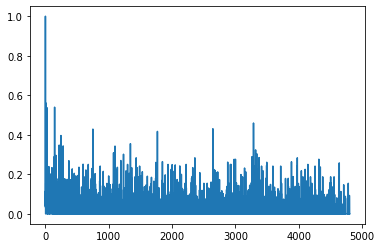

In [26]:
plt.plot(scores)

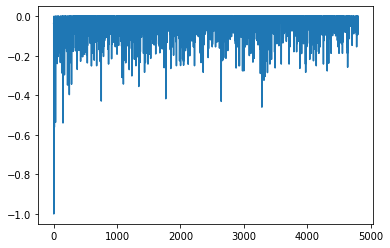

In [29]:
plt.plot(-scores)

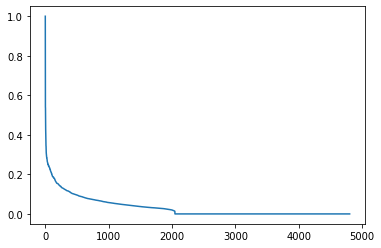

In [28]:
plt.plot(scores[(-scores).argsort()])

In [30]:
recommended_idx = (-scores).argsort()[1:6]

In [31]:
df['title'].iloc[recommended_idx]

11      Quantum of Solace
147       Die Another Day
29                Skyfall
3285             Restless
2644            Ong Bak 2
Name: title, dtype: object

In [32]:
def recommendationsFor(movie):
  idx = movieIndex[movie]
  query = tdm[idx]
  scores = cosine_similarity(query, tdm)
  scores = scores.flatten()
  recommended_idx = (-scores).argsort()[1:6]
  return df['title'].iloc[recommended_idx]

In [33]:
recommendationsFor('Spectre')

11      Quantum of Solace
147       Die Another Day
29                Skyfall
3285             Restless
2644            Ong Bak 2
Name: title, dtype: object

In [34]:
recommendationsFor('Scream 3')

3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object